# Lumin-human project geohackweek 2019
## Initial script to extract survey data based on the following study:
### Jean et al. Combining satellite imagery and machine learning to predict poverty. Science 19 Aug 2016: Vol. 353, Issue 6301, pp. 790-794. DOI: 10.1126/science.aaf7894 
#### Accompanying code from the paper is published here: https://github.com/nealjean/predicting-poverty


In this notebook, only parts of what they did in that paper is done: only one type of Survey data is used (LSMS) for one country (Tanzania)

written by: sumithra

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt

### Copy of R code from the scripts provided by Jean et al.  (for reference only)
### re: reading LSMS data for Tanzania 2012:

This is only for Tanzania - they do different things for other country data
 Tanzania 
```R
tza13.cons <- read.dta('data/input/LSMS/TZA_2012_LSMS_v01_M_STATA_English_labels/ConsumptionNPS3.dta') %$%
  data.frame(hhid = y3_hhid, cons = expmR/(365*adulteq))
tza13.cons$cons <- tza13.cons$cons*112.69/(585.52*mean(c(130.72,141.01)))
tza13.geo <- read.dta13('data/input/LSMS/TZA_2012_LSMS_v01_M_STATA_English_labels/HouseholdGeovars_Y3.dta')
tza13.coords <- data.frame(hhid = tza13.geo$y3_hhid, lat = tza13.geo$lat_dd_mod, lon = tza13.geo$lon_dd_mod)
tza13.hha <- read.dta('data/input/LSMS/TZA_2012_LSMS_v01_M_STATA_English_labels/HH_SEC_A.dta')
tza13.rururb <- data.frame(hhid = tza13.hha$y3_hhid, rururb = tza13.hha$y3_rural, stringsAsFactors = F)
tza13.weight <- read.dta('data/input/LSMS/TZA_2012_LSMS_v01_M_STATA_English_labels/HH_SEC_A.dta')[,c('y3_hhid', 'y3_weight')]
names(tza13.weight) <- c('hhid', 'weight')
tza13.hhi <- read.dta('data/input/LSMS/TZA_2012_LSMS_v01_M_STATA_English_labels/HH_SEC_I.dta')
tza13.room <- na.omit(data.frame(hhid = tza13.hhi$y3_hhid, room = tza13.hhi$hh_i07_1))
tza13.metal <- data.frame(hhid = tza13.hhi$y3_hhid, metal = tza13.hhi$hh_i09=='METAL SHEETS (GCI)')

tza13.vars <- list(tza13.cons, tza13.coords, tza13.rururb, tza13.weight, tza13.room, tza13.metal) %>%
  Reduce(function(x, y) merge(x, y, by = 'hhid'), .) %>%
  nl(2013)

write.table(tza13.vars, 'data/output/LSMS/Tanzania 2013 LSMS (Household).txt', row.names = F)
write.table(cluster(tza13.vars), 'data/output/LSMS/Tanzania 2013 LSMS (Cluster).txt', row.names = F
```

The script from the authors point to a link that is no longer active, the currently available data at https://microdata.worldbank.org/index.php/catalog/2252 is slightly different, but similar data is contained

#### First step: data from the collections of files provided in the LSMS survey to save for this work: 

consumption: ConsumptionNPS3.csv, Householdgeovars: HouseholdGeovars_Y3.csv, HH_SEC_A: HH_SEC_A.csv, HH_SEC_I: HH_SEC_I.csv

1: Just to explore - all columns contained in ConsumptionNPS3.csv
Columns: "y3_hhid","foodbev","alctob","foodIN","foodOUT","utilities","hhexpenses","health","transport","communic","recreat","educa","other","expm","fisherb3c3","foodbevR","alctobR","foodINR","foodOUTR","utilitiesR","hhexpensesR","healthR","transportR","communicR","recreatR","educaR","otherR","expmR","hhsize","expmR","urban","region","area","mainland","quarter"

In [2]:
## To keep: y3_hhid, expmR, adulteq

In [3]:
# Reading in the data into the variable consumption - NOTE path needs to be changed!
consumption = pd.read_csv('/Users/sumithra/DSV/MeDESTO/geohackweek2019/TZA_2012_NPS-R3_v01_M_CSV/ConsumptionNPS3.csv')

In [4]:
## Just a look at what's in there:
consumption.head()

,y3_hhid,foodbev,alctob,foodIN,foodOUT,utilities,hhexpenses,health,transport,communic,...,educaR,otherR,expmR,hhsize,adulteq,urban,region,area,mainland,quarter
0,0001-001,878800.0,0.0,878800.0,0,59200,123200,656500,0,120000,...,0.000000,27853.652344,1.966742e+06,4,3.60,1,1,3,1,1
1,0002-001,475800.0,0.0,444600.0,31200,31800,3600,0,0,0,...,0.000000,24266.439453,5.636144e+05,4,2.84,1,1,3,1,1
2,0003-001,3536000.0,93600.0,3265600.0,364000,257200,180000,0,336000,180000,...,214177.703125,430465.531250,5.479784e+06,6,5.28,1,1,3,1,1
3,0003-010,3445000.0,0.0,2472600.0,972400,602000,268000,303000,322400,300000,...,0.000000,193136.468750,4.906560e+06,4,3.24,2,7,1,1,1
4,0005-001,2522375.5,0.0,2418375.5,104000,96600,102800,67600,300000,57600,...,9495.563477,107616.382812,3.437368e+06,5,3.60,1,1,3,1,1


In [5]:
## We want to only save a few columns, passing these into the variable df
df = consumption[['y3_hhid', 'expmR', 'adulteq']]

In [6]:
## Function based on what they did in their script - average yearly consumption (?)
def to_cons(row):
    return row['expmR']/365*row['adulteq']
    

In [7]:
## Just a quick look at the new dataframe
df.head()

,y3_hhid,expmR,adulteq
0,0001-001,1.966742e+06,3.60
1,0002-001,5.636144e+05,2.84
2,0003-001,5.479784e+06,5.28
3,0003-010,4.906560e+06,3.24
4,0005-001,3.437368e+06,3.60


In [8]:
## Applying the function 'to_cons' and saving in a new column 'cons'
df['cons'] = df.apply(to_cons, axis=1)

/Users/sumithra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
## Second calculation from the provided script - this probably relates to normalising currency (?)
def calc_converted_values(row):
    return row*112.69/(585.52*np.mean([130.72,141.01]))

In [10]:
## Applying the function and saving in a new column value 'cons2'
df['cons2'] = df['cons'].apply(calc_converted_values)

/Users/sumithra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
## Now we have these two new columns in our dataframe
df.head()

,y3_hhid,expmR,adulteq,cons,cons2
0,0001-001,1.966742e+06,3.60,19398.004649,27.478506
1,0002-001,5.636144e+05,2.84,4385.383574,6.212174
2,0003-001,5.479784e+06,5.28,79269.204630,112.289863
3,0003-010,4.906560e+06,3.24,43554.125810,61.697186
4,0005-001,3.437368e+06,3.60,33902.807615,48.025480


In [12]:
## Next step is to load the geo variables from the survey data
#tza13.geo <- read.dta13('data/input/LSMS/TZA_2012_LSMS_v01_M_STATA_English_labels/HouseholdGeovars_Y3.dta')
geo = pd.read_csv('/Users/sumithra/DSV/MeDESTO/geohackweek2019/TZA_2012_NPS-R3_v01_M_CSV/HouseholdGeovars_Y3.csv')

In [13]:
## We only need to save id, latitude and longitude values
dfgeo = geo[['y3_hhid', 'lat_dd_mod', 'lon_dd_mod']]

In [14]:
## Quick look at the dataframe with geo variables (dfgeo)
dfgeo.head()

,y3_hhid,lat_dd_mod,lon_dd_mod
0,0001-001,-5.085751,35.854389
1,0002-001,-5.085751,35.854389
2,0003-001,-5.085751,35.854389
3,0003-010,-6.860888,39.251984
4,0005-001,-5.085751,35.854389


In [15]:
## Let's now merge the two dataframes so that we can get geo locations for the consumption values 
# - saving in a new dataframe: df_merged
df_merged = pd.merge(df, dfgeo, on='y3_hhid')

In [16]:
## How many individual values do we have?
len(df_merged)

4862

In [17]:
df_merged.head()

,y3_hhid,expmR,adulteq,cons,cons2,lat_dd_mod,lon_dd_mod
0,0001-001,1.966742e+06,3.60,19398.004649,27.478506,-5.085751,35.854389
1,0002-001,5.636144e+05,2.84,4385.383574,6.212174,-5.085751,35.854389
2,0003-001,5.479784e+06,5.28,79269.204630,112.289863,-5.085751,35.854389
3,0003-010,4.906560e+06,3.24,43554.125810,61.697186,-6.860888,39.251984
4,0005-001,3.437368e+06,3.60,33902.807615,48.025480,-5.085751,35.854389


#### In the paper, they cluster household/consumption values to 
##### Cluster function from the paper - for reference only

```R
# Aggregate household-level data to cluster level
cluster <- function(df, dhs = F){
  # Record how many households comprise each cluster
  for (i in 1:nrow(df)){
    sub <- subset(df, lat == df$lat[i] & lon == df$lon[i])
    df$n[i] <- nrow(sub)
  }
  # Clustering for LSMS survey data
  df <- if (dhs == FALSE)
    ddply(df, .(lat, lon), summarise,
          cons = mean(cons),
          nl = mean(nl),
          n = mean(n),
          sample = min(sample))
  # Clustering for DHS survey data
  else ddply(df, .(lat, lon), summarise,
             wealthscore = mean(wealthscore),
             nl = mean(nl),
             n = mean(n),
             sample = min(sample))
  return(df)
}
```

In [18]:
## Replication of clustering:

## First filter out any rows where the latitude + longitude only occurs once (i.e. only one household):
filtered = df_merged.groupby(['lat_dd_mod', 'lon_dd_mod']).filter(lambda x: len(x) > 1)

## Then calculate the mean cons2 for each cluster of lat+lon households
filtered.groupby(['lat_dd_mod', 'lon_dd_mod'])['cons2'].mean()

lat_dd_mod  lon_dd_mod
-11.497012  35.607626      42.264669
-11.315454  34.786297      33.312532
-11.170319  34.996472      23.262399
-11.108790  34.642166      48.164958
-11.072451  37.319251      24.731698
                             ...    
-1.335650   31.822935      88.142518
-1.324776   34.354972     151.964764
-1.213422   31.665497      68.447434
-1.213010   31.463951      38.937077
-1.058783   30.697008     114.735566
Name: cons2, Length: 409, dtype: float64

In [19]:
df_merged['lon_dd_mod'].dtype

dtype('float64')

### Some initial experiments in plotting these points on a map - to be continued

Questions:
- Why are the points slightly off on the map?
- How to add legend (legend = True does not seem to work?)?
- Other shape files for Tanzania?

In [58]:
## Converting lat+lon to points
geometry = [shapely.geometry.Point(xy) for xy in zip(df_merged['lon_dd_mod'], df_merged['lat_dd_mod'])]

In [59]:
geometry[:3]

In [60]:
## creating a geopandas dataframe with the points on all the data (i.e. no clusters)
geo_df = gpd.GeoDataFrame(df_merged, geometry=geometry)
geo_df.crs = {'init' :'epsg:4326'}

In [61]:
geo_df.head()

,y3_hhid,expmR,adulteq,cons,cons2,lat_dd_mod,lon_dd_mod,geometry
0,0001-001,1.966742e+06,3.60,19398.004649,27.478506,-5.085751,35.854389,POINT (35.8543891943 -5.08575059837)
1,0002-001,5.636144e+05,2.84,4385.383574,6.212174,-5.085751,35.854389,POINT (35.8543891943 -5.08575059837)
2,0003-001,5.479784e+06,5.28,79269.204630,112.289863,-5.085751,35.854389,POINT (35.8543891943 -5.08575059837)
3,0003-010,4.906560e+06,3.24,43554.125810,61.697186,-6.860888,39.251984,POINT (39.2519840813 -6.86088773309)
4,0005-001,3.437368e+06,3.60,33902.807615,48.025480,-5.085751,35.854389,POINT (35.8543891943 -5.08575059837)


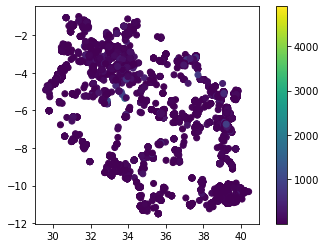

In [62]:
fig, ax = plt.subplots(1, 1)
geo_df.plot(column='cons2', ax=ax, legend=True);

In [63]:
## Same thing with the filtered data
geometry_filtered = [shapely.geometry.Point(xy) for xy in zip(filtered['lon_dd_mod'], filtered['lat_dd_mod'])]

In [64]:
geo_df_filtered = gpd.GeoDataFrame(filtered, geometry=geometry_filtered)
geo_df_filtered.crs = {'init' :'epsg:4326'}

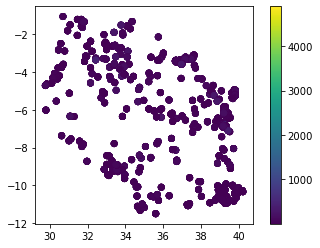

In [65]:
fig, ax = plt.subplots(1, 1)
geo_df_filtered.plot(column='cons2', ax=ax, legend=True, figsize=(10, 10));

In [66]:
## Reading in world map from tutorial material
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
## Keeping only Tanzania
tan = world[world['name']=='Tanzania']

In [67]:
tan.crs

{'init': 'epsg:4326'}

In [68]:
## From tutorial material - not used with the current data
import requests
import geojson

wfs_url = "http://data.nanoos.org/geoserver/ows"
params = dict(service='WFS', version='1.0.0', request='GetFeature',
              typeName='oa:goaoninv', outputFormat='json')

r = requests.get(wfs_url, params=params)
wfs_geo = geojson.loads(r.content)

In [69]:
print(type(wfs_geo))
print(wfs_geo.keys())
print(len(wfs_geo.__geo_interface__['features']))

<class 'geojson.feature.FeatureCollection'>
dict_keys(['type', 'totalFeatures', 'crs', 'features'])
610


In [70]:
wfs_gdf = gpd.GeoDataFrame.from_features(wfs_geo)

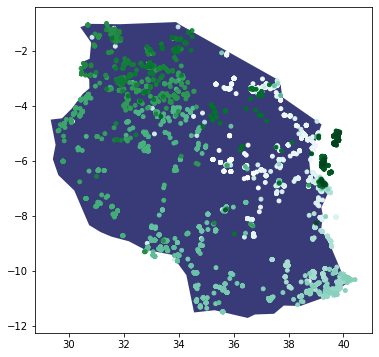

In [71]:
## Plot with full survey dataset
geo_df.plot(ax=tan.plot(cmap='tab20b', figsize=(10, 6)),
             marker='o', markersize=15, cmap='BuGn', legend = True, legend_kwds={'loc': 'lower right'});

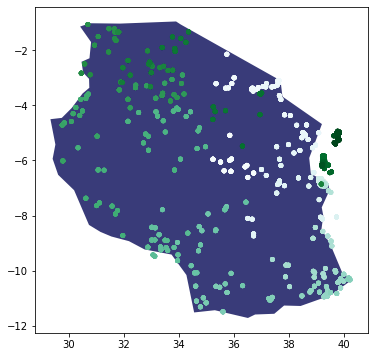

In [72]:
## Plot with filtered (clustered) survey dataset
geo_df_filtered.plot(ax=tan.plot(cmap='tab20b', figsize=(10, 6)),
             marker='o', markersize=15, cmap='BuGn', legend = True, legend_kwds={'loc': 'lower right'});